In [1]:
import requests
from tqdm import tqdm
from requests.auth import HTTPBasicAuth
from pprint import pprint
import pandas as pd
import numpy as np
from highlight_text import fig_text, ax_text
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib import cm

from PIL import Image
import urllib
import matplotlib.font_manager as fm
from highlight_text import fig_text

import os

username = 'qjpuw3t-yf3bvhgms-8d0gift-bm2fprvs4z'
token =  '7*.w$Ivko$FpRsbumn0gF(0Kc5yMAI'

base_url = 'https://apirest.wyscout.com/v3{}'


In [2]:
footMobId = {'Fiorentina': 8535,
 'Milan': 8564,
 'Atalanta': 8524,
 'Bologna': 9857,
 'Cremonese': 7801,
 'Empoli': 8534,
 'Hellas Verona': 9876,
 'Internazionale': 8636,
 'Juventus': 9885,
 'Lazio': 8543,
 'Lecce': 9888,
 'Monza': 6504,
 'Roma': 8686,
 'Napoli': 9875,
 'Salernitana': 6480,
 'Sampdoria': 9882,
 'Sassuolo': 7943,
 'Spezia': 9881,
 'Torino': 9804,
 'Udinese': 8600,
 'Genoa': 10233,
 'Cagliari': 8529,
 'Venezia': 7881,
 'Benevento': 6266,
 'Crotone': 9884,
 'Parma': 10167,
 'Brescia': 9858,
 'Spal': 8547}

ColorCode = {
 'Fiorentina': "#482E92",
 'Milan': "#FB090B",
 'Atalanta': "#1E71B8",
 'Bologna': "#1A2F48",
 'Cremonese': "#AD1919",
 'Empoli': "#00579C",
 'Hellas Verona': "#FFE74A",
 'Internazionale': "#005CA8",
 'Juventus': "#000000",
 'Lazio': "#87D8F7",
 'Lecce': "#ED1B23",
 'Monza': "#ED1B23",
 'Roma': "#F0BC42",
 'Napoli': "#003C82",
 'Salernitana': "#8A1E03",
 'Sampdoria': "#2345C0",
 'Sassuolo': "#00A752",
 'Spezia': "#000000",
 'Torino': "#8A1E03",
 'Udinese': "#000000"
}

Players, Teams

In [3]:
SerieA = 524

A_Season_21_22 = 187528
A_Season_20_21 = 186353
A_Season_19_20 = 186353
A_Season_22_23 = 188160

FiorentinaId = 3176
available_seasons = [(SerieA,A_Season_22_23)]

players,teams = [],[]
players_season = {}

for season in available_seasons:
    api_url = base_url.format(f'/seasons/{season[1]}/teams')
    response = requests.get(api_url, auth=HTTPBasicAuth(username, token))
    if response.ok:
        team = response.json()['teams']
        teams+=team


team_name = {}
for team in teams:
  team_name[team['wyId']] = team['name']



match events

In [4]:
events = []
matches = []
gameweek = 2

for season in available_seasons:
    
    #api_url = base_url.format(f'/teams/{FiorentinaId}/matches?seasonId={season[1]}')
    api_url = base_url.format(f'/competitions/{SerieA}/matches')
    response = requests.get(api_url, auth=HTTPBasicAuth(username, token))
    if response.ok:
      season_matches = response.json()['matches']
    else:
      print("errore")
      break
    last_season_matches = []
    for match in season_matches:
      if match['seasonId'] == season[1] and match['gameweek'] == gameweek:
        last_season_matches.append(match)
    for m in tqdm(last_season_matches):
        api_url = base_url.format('/matches/%s/events'%(m['matchId']))
        response = requests.get(api_url, auth=HTTPBasicAuth(username, token))
        if response.ok:
            match_events = response.json()['events']
            events += match_events

        
        api_url = base_url.format('/matches/%s'%(m['matchId']))
        response = requests.get(api_url, auth=HTTPBasicAuth(username, token))
        if response.ok:
            matches.append( response.json())

    for team in team_name.keys():
      api_url = base_url.format(f'/teams/{team}/squad?seasonId={season[1]}')
      response = requests.get(api_url, auth=HTTPBasicAuth(username, token))
      if response.ok:
        player = response.json()['squad']
        players+=player
      for p in player:
          players_season[p['wyId']] = season
    
        
player_name = {}
for p in players:
  player_name[p['wyId']] = [p['shortName'], p['role']['code3']]

team_name = {}
for t in teams:
  team_name[t['wyId']] = t['name']

match_name = {}
for m in matches:
  match_name[m['wyId']] = m['label']

100%|██████████| 10/10 [01:10<00:00,  7.01s/it]


In [5]:
ev_loc = []

#V2
"""
for i,ev in enumerate(events):
  doc1 = {}
  doc1['player'] = player_name[ev['playerId']][0].encode().decode('unicode_escape') if ev['playerId'] in player_name.keys() else "N.A."
  doc1['role'] =  player_name[ev['playerId']][1] if ev['playerId'] in player_name.keys() else ev['playerId']
  doc1['match'] = match_name[ev['matchId']]
  doc1['team'] = team_name[ev['teamId']]
  doc1['eventName'] = ev['eventName']
  doc1['subEventName'] = ev['subEventName']
  doc1['eventId'] = ev['eventId']
  doc1['tags'] = ev['tags']
  doc1['subEventId'] = ev['subEventId']
  doc1['matchPeriod'] = ev['matchPeriod']
  doc1['x'] = ev['positions'][0]['x']
  doc1['y'] = ev['positions'][0]['y']
  ev_loc.append(doc1)
"""
#V3
# SHOTS
for i,ev in enumerate(events):
  doc1 = {}
  if ev['shot'] != None:
    doc1['matchId'] = ev['matchId']
    doc1['match'] = match_name[ev['matchId']]
    doc1['matchPeriod'] = ev['matchPeriod']
    if doc1['matchPeriod']=="1H":
      doc1['min'] = ev['minute'] if ev['minute'] < 46 else 45
      doc1['sec'] = ev['second'] if ev['minute'] < 46 else 0
    else:
      doc1['min'] = ev['minute'] if ev['minute'] < 91 else 90
      doc1['sec'] = ev['second'] if ev['minute'] < 91 else 0
    doc1['playerId'] = ev['player']['id']
    doc1['player'] = ev['player']['name']
    doc1['role'] =  ev['player']['position']
    doc1['teamName'] = team_name[ev['team']['id']]
    doc1['teamId'] = footMobId[doc1['teamName']]
    doc1['teamColor'] = ColorCode[doc1['teamName']]
    doc1['eventName'] = "shot"
    doc1['bodyPart'] = ev['shot']['bodyPart']
    doc1['onTarget'] = ev['shot']['onTarget']
    doc1['isGoal'] = ev['shot']['isGoal']
    doc1['isOwnGoal'] = False
    doc1['goalZone'] = ev['shot']['goalZone']
    doc1['xG'] = ev['shot']['xg']
    doc1['PSxG'] = ev['shot']['postShotXg']
    if (doc1['isGoal']):
      doc1['eventType'] = 'Goal'
    elif (ev['shot']['goalkeeper'] != None):
      doc1['eventType'] = 'AttemptSaved'
    else:
      doc1['eventType'] = 'Miss'
    if ev['shot']['goalkeeper'] != None:
      doc1['GKId'] = int(ev['shot']['goalkeeper']['id'])
      doc1['GKname'] = ev['shot']['goalkeeper']['name']
    doc1['x'] = ev['location']['x']
    doc1['y'] = ev['location']['y']
    if (doc1['match'].split()[0] == doc1['teamName'].split()[0]):
      doc1['venue'] = 'H'
    else:
      doc1['venue'] = 'A'
    ev_loc.append(doc1)
  elif (ev['type']['primary'] == "own_goal"):
    doc1['matchId'] = ev['matchId']
    doc1['match'] = match_name[ev['matchId']]
    doc1['matchPeriod'] = ev['matchPeriod']
    doc1['min'] = ev['minute']
    doc1['sec'] = ev['second']
    doc1['playerId'] = ev['player']['id']
    doc1['player'] = ev['player']['name']
    doc1['role'] =  ev['player']['position']
    doc1['teamName'] = team_name[ev['team']['id']]
    doc1['teamId'] = footMobId[doc1['teamName']]
    doc1['teamColor'] = ColorCode[doc1['teamName']]
    doc1['eventName'] = "own-goal"
    doc1['eventType'] = 'Goal'
    doc1['bodyPart'] = "NA"
    doc1['onTarget'] = True
    doc1['isGoal'] = False
    doc1['isOwnGoal'] = True
    doc1['goalZone'] = "NA"
    doc1['xG'] = 0
    doc1['PSxG'] = 0
    #if ev['shot']['goalkeeper'] != None:
    #  doc1['GKId'] = int(ev['shot']['goalkeeper']['id'])
    #  doc1['GKname'] = ev['shot']['goalkeeper']['name']
    doc1['x'] = ev['location']['x']
    doc1['y'] = ev['location']['y']
    if (doc1['match'].split()[0] == doc1['teamName']):
      doc1['venue'] = 'H'
    else:
      doc1['venue'] = 'A'
    ev_loc.append(doc1)

df = pd.DataFrame(ev_loc)

In [6]:
import json
filets = "./data/shots_SerieA_2022_2023_" + str(gameweek) + ".json"
json.dump(events,  open(filets,"w"))

In [7]:
font_path = "../Fonts"
for x in os.listdir(font_path):
    for y in os.listdir(f'{font_path}/{x}'):
        if y.split('.')[-1] == 'ttf':
            fm.fontManager.addfont(f'{font_path}/{x}/{y}')
            try:
                fm.FontProperties(weight=y.split('-')[-1].split('.')[0].lower(), fname=y)
            except Exception as e:
                print(f'Font {y} could not be added.')
                continue

rcParams['font.family'] = 'Karla'

Font DMSans-BoldItalic.ttf could not be added.
Font DMSans-Italic.ttf could not be added.
Font DMSans-MediumItalic.ttf could not be added.
Font Karla-BoldItalic.ttf could not be added.
Font Karla-Italic.ttf could not be added.


In [8]:
df['min'] = df['min'].astype(int)
df['xG'] = df['xG'].astype(float)

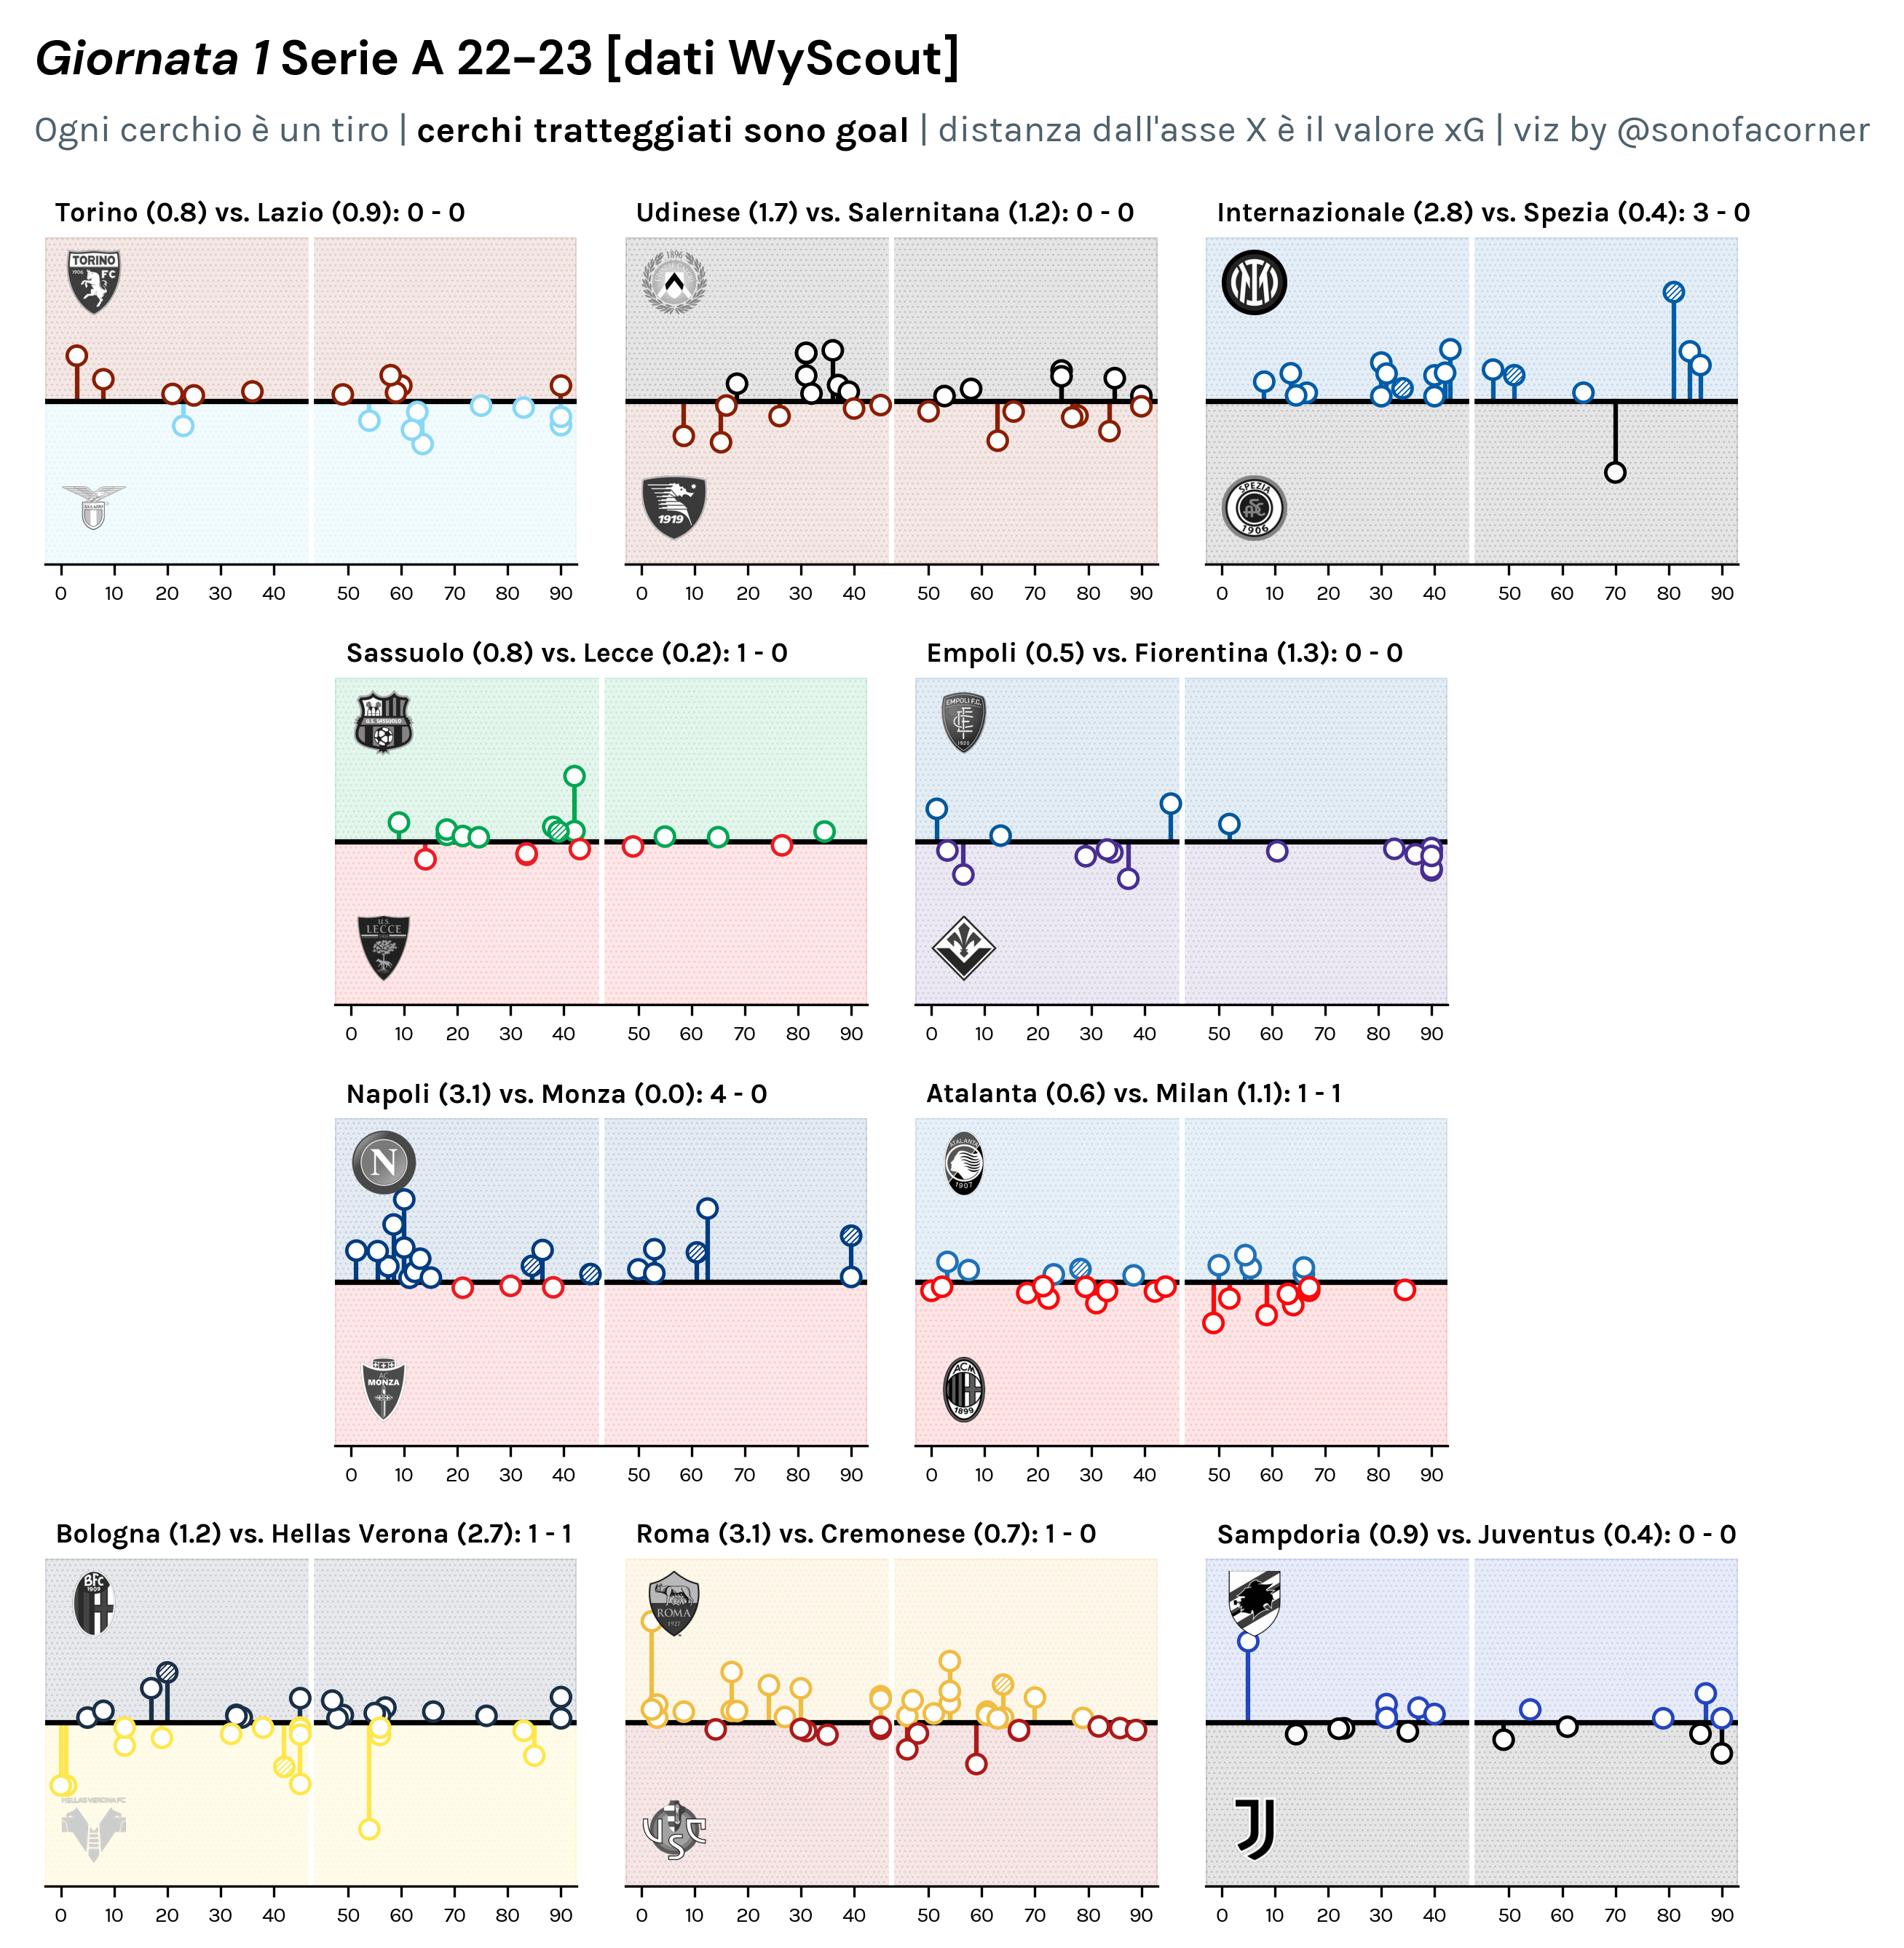

In [9]:
def plot_axes_xg_by_match(ax, fig, matchId, data=df):
    '''
    This function plots the xG lollipop chart for a given match
    id.
    '''
    df = data.copy()
    match_df = df[df['matchId'] == matchId].reset_index(drop=True)
    match_df.sort_values(by='min', ascending=True).reset_index(drop=True)

    home_conditional = (match_df['venue'] == 'H')
    away_conditional = (match_df['venue'] == 'A')

    # -- Clean up the axes
    ax.set_ylim(-1.05,1.05)
    ax.set_xlim(-5,95)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks([])
    ax.xaxis.set_ticks(
        [x for x in range(-2,45,10)] + [x for x in range(52,102,10)],
        labels=[x for x in range(0,91,10)]
    )
    ax.tick_params(labelsize=7)

    plt.rcParams['hatch.linewidth'] = 0.45

    home_color = match_df[home_conditional]['teamColor'].iloc[0]
    for index, shot in enumerate(match_df[home_conditional]['xG']):
        minute = match_df[home_conditional]['min'].iloc[index]
        if minute < 46:
            offset_x = -2
        else:
            offset_x = 2
        ax.plot([minute + offset_x, minute + offset_x], [0, shot], color=home_color)
        if match_df[home_conditional]['eventType'].iloc[index] != 'Goal':
            hatch = ''
        else:
            hatch = '/////////////'
        ax.scatter([minute + offset_x], [shot + .025], marker='o', s=40, hatch=hatch, 
                color="white", zorder=3, lw=1.15, ec=home_color)

    away_color = match_df[away_conditional]['teamColor'].iloc[0]
    for index, shot in enumerate(match_df[away_conditional]['xG']):
        minute = match_df[away_conditional]['min'].iloc[index]
        if minute < 46:
            offset_x = -2
        else:
            offset_x = 2
        ax.plot([minute + offset_x, minute + offset_x], [0, -1*shot], color=away_color)
        if match_df[away_conditional]['eventType'].iloc[index] != 'Goal':
            hatch = ''
        else:
            hatch = '/////////////'
        ax.scatter([minute + offset_x], [-1*shot - .025], marker='o', s=40, hatch=hatch, 
                color="white", zorder=3, lw=1.15, ec=away_color)

    # --- Make it pretty ---
    ax.plot([-5,95], [0,0], color='black', lw=1.75)
    ax.plot([45,45], [-1.05,1.05], color='white', lw=1.75, zorder=2)
    ax.fill_between(
        x=[-5,95], y1=[0], y2=[1.05],
        color=home_color, alpha=0.1, zorder=1,
        hatch="......."
    )
    ax.fill_between(
        x=[-5,95], y1=[0], y2=[-1.05],
        color=away_color, alpha=0.1, zorder=1,
        hatch="......."
    )

    # --- Add the logos and legend ---
    home_team_id = match_df[home_conditional]['teamId'].iloc[0]
    away_team_id = match_df[away_conditional]['teamId'].iloc[0]
    home_team_name = match_df[home_conditional]['teamName'].iloc[0]
    away_team_name = match_df[away_conditional]['teamName'].iloc[0]

    DC_to_FC = ax.transData.transform
    FC_to_NFC = fig.transFigure.inverted().transform
    # Native data to normalized data coordinates
    DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))

    fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'

    ax_coords = DC_to_NFC([-2, .55])
    logo_ax = fig.add_axes([ax_coords[0], ax_coords[1], 0.03, 0.03], anchor = 'W')
    club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{home_team_id:.0f}.png')).convert("LA")
    logo_ax.imshow(club_icon)
    logo_ax.axis('off')

    ax_coords = DC_to_NFC([-2, -.9])
    logo_ax = fig.add_axes([ax_coords[0], ax_coords[1], 0.03, 0.03], anchor = 'W')
    club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{away_team_id:.0f}.png')).convert("LA")
    logo_ax.imshow(club_icon)
    logo_ax.axis('off')

    # --- Compute goals and xG
    home_xG = match_df[home_conditional & (match_df['isOwnGoal'] == False)]['xG'].sum()
    away_xG = match_df[away_conditional & (match_df['isOwnGoal'] == False)]['xG'].sum()
    home_goals = (match_df[home_conditional & (match_df['isOwnGoal'] == False)]['eventType'] == 'Goal').sum() + (match_df[away_conditional & (match_df['isOwnGoal'] == True)]['eventType'] == 'Goal').sum()
    away_goals = (match_df[away_conditional & (match_df['isOwnGoal'] == False)]['eventType'] == 'Goal').sum() + (match_df[home_conditional & (match_df['isOwnGoal'] == True)]['eventType'] == 'Goal').sum()


    ax.annotate(
        xy=(0.02, 1.05),
        text=f'{home_team_name} ({home_xG:.1f}) vs. {away_team_name} ({away_xG:.1f}): {home_goals} - {away_goals}',
        xycoords='axes fraction',
        weight='bold',
        size=9
    )

    return ax


# --- The Final Visual

layout_ = '''
    AABBCC
    ......
    .GGHH.
    ......
    .IIJJ.
    ......
    DDEEFF
'''

height_ratios = [1,.05,1,.05,1,.05,1]

f = plt.figure(figsize=(10,10), dpi=300)
axs = f.subplot_mosaic(
    layout_, 
    gridspec_kw={
        'height_ratios':height_ratios,
        'hspace': 0.25
    }
)

counter = 0
df = df.sort_values(by='matchId').reset_index(drop=True)
matches = list(df['matchId'].unique())
for k, ax in axs.items():
    matchId = matches[counter]
    plot_axes_xg_by_match(ax, f, matchId=matchId, data=df)
    counter += 1


fig_text(
    x = 0.12, y = .95, 
     s = "<Giornata 1> Serie A 22-23 [dati WyScout]",
    highlight_textprops=[{"style":"italic"}],
    va = "bottom", ha = "left",
    fontsize = 16, color = "black", font = "DM Sans", weight = "bold"
)
fig_text(
	x = 0.12, y = .92, 
    s = "Ogni cerchio è un tiro | <cerchi tratteggiati sono goal> | distanza dall'asse X è il valore xG | viz by @sonofacorner",
    highlight_textprops=[{"weight": "bold", "color": "black"}],
	va = "bottom", ha = "left",
	fontsize = 12, color = "#4E616C", font = "Karla"
)

plt.savefig(
	"figures/15082022_serieA_round1_XG_lollipop.png",
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)

plt.savefig(
	"figures/15082022_serieA_round1XG_lollipop_tr.png",
	dpi = 600,
	facecolor = "none",
	bbox_inches="tight",
    edgecolor="none",
	transparent = True
)

============================ Summary Table

In [10]:
cond = df['eventType']=='Goal'
df['Goal'] = cond + 0

cond = (df['goalZone'] == 'bc') | (df['goalZone'] == 'gb') | (df['goalZone'] == 'gbr') | (df['goalZone'] == 'gc') | (df['goalZone'] == 'gl') | \
    (df['goalZone'] == 'glb') | (df['goalZone'] == 'gr') | (df['goalZone'] == 'gt') | (df['goalZone'] == 'gtl') | (df['goalZone'] == 'gtr')
df['shotOT'] = cond + 0

In [11]:
df_1 = df.groupby(['match', 'teamName', 'teamId', 'venue'])

In [12]:
df_2 = df_1.agg(xG_sum=pd.NamedAgg(column='xG', aggfunc='sum'),
            PSxG_sum=pd.NamedAgg(column='PSxG', aggfunc='sum'),
            team_score=pd.NamedAgg(column='Goal', aggfunc='sum'),
            team_shots=pd.NamedAgg(column='goalZone', aggfunc='count'),
            team_shotsOT=pd.NamedAgg(column='shotOT', aggfunc='sum'),
            )

#df_2.groupby(level=0)[['xG_sum', 'PSxG_sum', 'team_score', 'team_shots', 'team_shotsOT']].apply(lambda x: x.sort_values()).reset_index(level=0,drop=True)
df_2.sort_values(by=['match','venue'], inplace=True, ascending=True)
df_2.reset_index(inplace=True)
# manual fix own goal
df_2.iloc[6,6] = 1
df_2.iloc[7,6] = 2

In [13]:
games = {}
for i, line in df_2.iterrows():
    if line['match'] in games.keys():
        games[line['match']].append(line['teamName']) #Home
        games[line['match']].append(line['teamId']) #Home
        games[line['match']].append(line['team_score']) #Home
        games[line['match']].append(line['xG_sum']) #Home
        games[line['match']].append(line['PSxG_sum']) #Home
        games[line['match']].append(line['team_shots']) #Home
        games[line['match']].append(line['team_shotsOT']) #Home
    else:
        games[line['match']] = [line['teamName'], line['teamId'], line['team_score'], line['xG_sum'], line['PSxG_sum'], line['team_shots'], line['team_shotsOT']] #Away

In [14]:
games_list = []
for k in games.keys():
    games_list.append(games[k])

# convert the list into dataframe row
df = pd.DataFrame(games_list)
# add columns
df.columns = ['away_team_name', 'away_team_id', 'away_team_score', 'away_team_xG', 'away_team_PSxG', 'away_team_shots', 'away_team_shotsOT', \
    'home_team_name', 'home_team_id', 'home_team_score', 'home_team_xG', 'home_team_PSxG', 'home_team_shots', 'home_team_shotsOT']


In [15]:
colors = [
    '#efe9e6',
    '#e9e1dd',
    '#e3dad3',
    '#dcd3c9',
    '#d4ccc0',
    '#ccc6b7',
    '#c3bfae',
    '#bab9a6',
    '#b0b39e',
    '#a6ad96',
    '#9ba790',
    '#90a18a',
    '#849b84',
    '#789680',
    '#6c907c',
    '#608a79',
    '#538476',
    '#467e74',
    '#387872',
    '#287271',
]
soc_cm = LinearSegmentedColormap.from_list('SOC', colors, N=50)
cm.register_cmap(name='SOC', cmap=soc_cm)

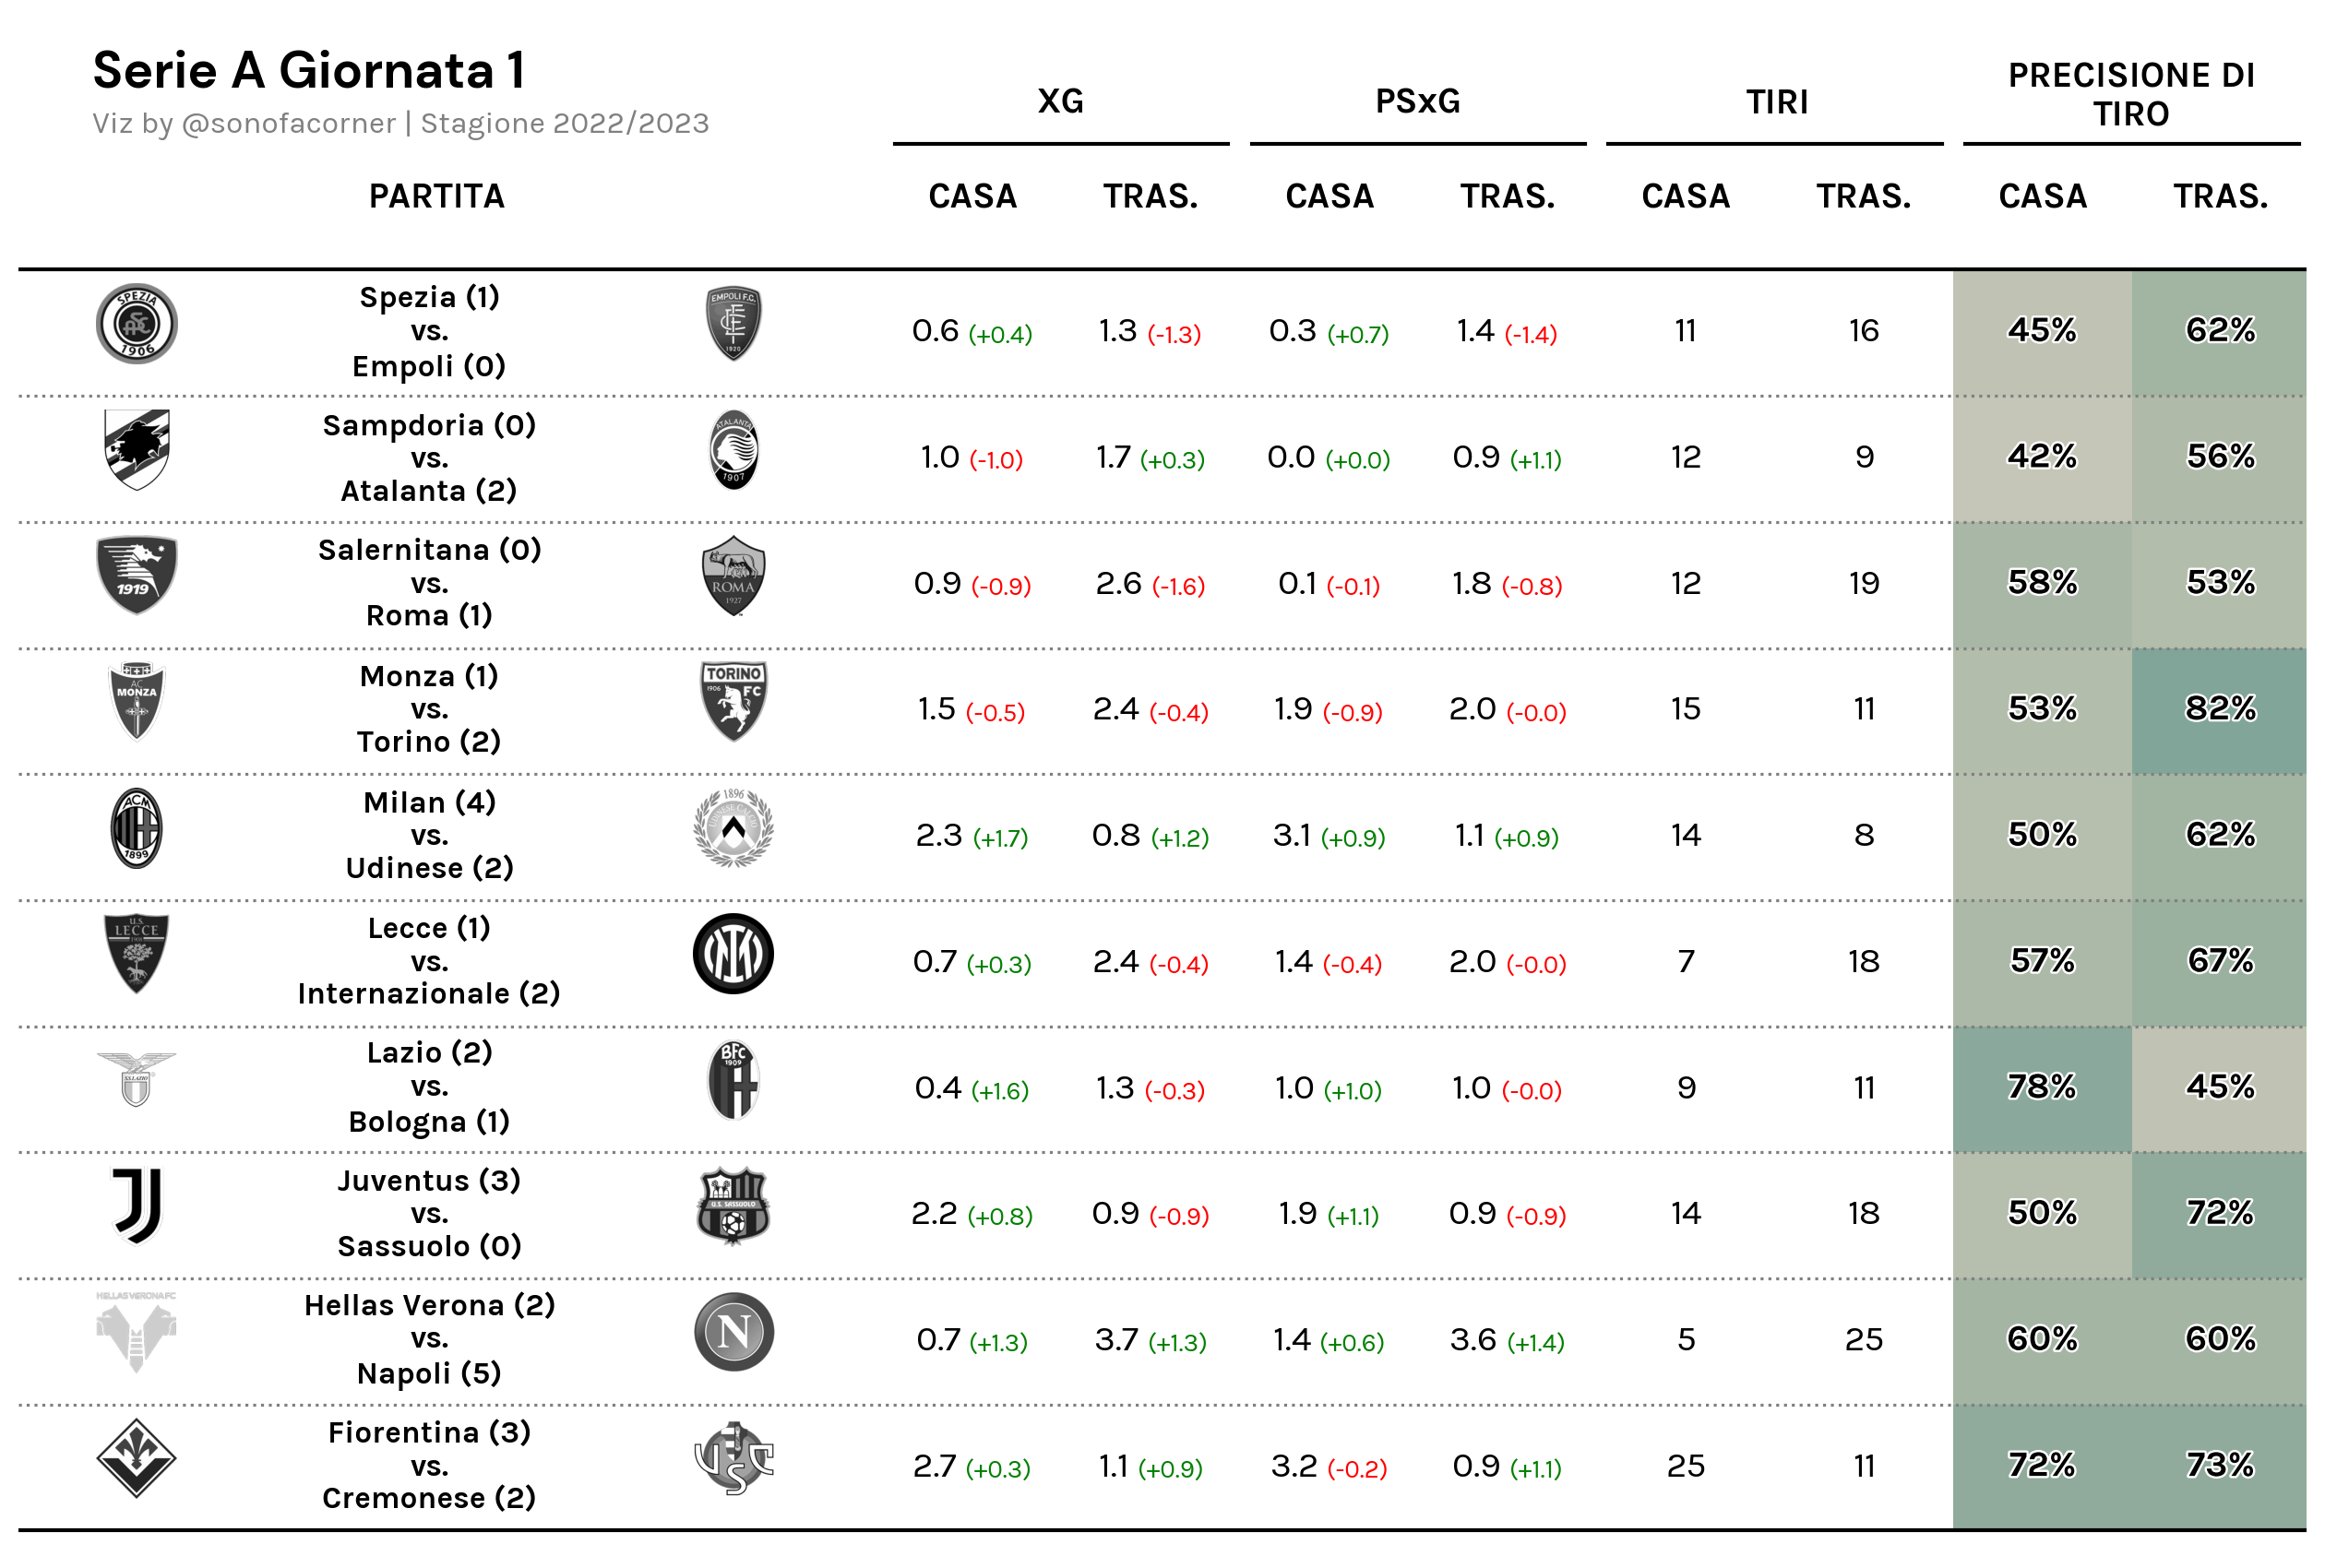

In [16]:
fig = plt.figure(figsize=(16, 11), dpi = 200)
ax = plt.subplot(111, facecolor = "#EFE9E6")

ncols = 14 
nrows = df.shape[0]

#df = df.sort_values(by='date', ascending=False).reset_index(drop=True)

ax.set_xlim(0, ncols + .75)
ax.set_ylim(-.15, nrows + 2)

# --- Define URL and helper functions to add logos --------------------------------

fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
# Native data to normalized data coordinates
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))

# -- The CMAP fot the gradient
cmap = cm.get_cmap('SOC')

for y in range(nrows):
    # -----------------------------------------
    # - Home logo
    x = 0
    team_id = df['home_team_id'].iloc[y]
    ax_coords = DC_to_NFC([x + .5, y + .25])
    logo_ax = fig.add_axes([ax_coords[0], ax_coords[1], 0.04, 0.04], anchor = "W")
    club_icon = Image.open(urllib.request.urlopen(f"{fotmob_url}{team_id:.0f}.png")).convert("LA")
    logo_ax.imshow(club_icon)
    logo_ax.axis("off")
    # -----------------------------------------
    # - Fixture result
    x = 2.65
    home_name = df['home_team_name'].iloc[y]
    away_name = df['away_team_name'].iloc[y]
    home_score = df['home_team_score'].iloc[y]
    away_score = df['away_team_score'].iloc[y]
    label_ = f'{home_name} ({home_score:.0f})\nvs.\n{away_name} ({away_score:.0f})'
    ax.annotate(
        xy=(x,y + 0.5),
        text=label_,
        ha='center',
        va='center',
        size=12,
        weight='bold'
    )
    # -----------------------------------------
    # - Away logo
    x = 5 
    team_id = df['away_team_id'].iloc[y]
    ax_coords = DC_to_NFC([x - .65, y + .25])
    logo_ax = fig.add_axes([ax_coords[0], ax_coords[1], 0.04, 0.04], anchor = "W")
    club_icon = Image.open(urllib.request.urlopen(f"{fotmob_url}{team_id:.0f}.png")).convert("LA")
    logo_ax.imshow(club_icon)
    logo_ax.axis("off")
    # -----------------------------------------
    # -- xGs
    home_xG = df['home_team_xG'].iloc[y]
    away_xG = df['away_team_xG'].iloc[y]
    xG_diff_h = home_score - home_xG
    xG_diff_a = away_score - away_xG
    # -- Home xG
    x = 6.15
    if xG_diff_h < 0:
        high_color='red'
        label_h_ = f'{home_xG:.1f} <({(xG_diff_h):.1f})>'
    else:
        high_color='green'
        label_h_ = f'{home_xG:.1f} <(+{(xG_diff_h):.1f})>'
    ax_text(
        x=x,y=y+0.5,
        s=label_h_,
        ha='center',
        va='center',
        highlight_textprops=[{'size':10,'color':high_color}],
        size=14,
        ax=ax
    )
    # -- Away xG
    x = 7.3
    if xG_diff_a < 0:
        high_color='red'
        label_a_ = f'{away_xG:.1f} <({(xG_diff_a):.1f})>'
    else:
        high_color='green'
        label_a_ = f'{away_xG:.1f} <(+{(xG_diff_a):.1f})>'
    ax_text(
        x=x,y=y+0.5,
        s=label_a_,
        ha='center',
        va='center',
        highlight_textprops=[{'size':10,'color':high_color}],
        size=14,
        ax=ax
    )
    # -----------------------------------------
    # -- PSxG
    home_PSxG = df['home_team_PSxG'].iloc[y]
    away_PSxG = df['away_team_PSxG'].iloc[y]
    PSxG_diff_h = home_score - home_PSxG
    PSxG_diff_a = away_score - away_PSxG
    # -- Home PSxG
    x = 8.45
    if PSxG_diff_h < 0:
        high_color='red'
        label_h_ = f'{home_PSxG:.1f} <({(PSxG_diff_h):.1f})>'
    else:
        high_color='green'
        label_h_ = f'{home_PSxG:.1f} <(+{(PSxG_diff_h):.1f})>'
    ax_text(
        x=x,y=y+0.5,
        s=label_h_,
        ha='center',
        va='center',
        highlight_textprops=[{'size':10,'color':high_color}],
        size=14,
        ax=ax
    )
    # -- Away PSxG
    x = 9.6
    if PSxG_diff_a < 0:
        high_color='red'
        label_a_ = f'{away_PSxG:.1f} <({(PSxG_diff_a):.1f})>'
    else:
        high_color='green'
        label_a_ = f'{away_PSxG:.1f} <(+{(PSxG_diff_a):.1f})>'
    ax_text(
        x=x,y=y+0.5,
        s=label_a_,
        ha='center',
        va='center',
        highlight_textprops=[{'size':10,'color':high_color}],
        size=14,
        ax=ax
    )
    # -----------------------------------------
    # -- Shots
    home_shots = df['home_team_shots'].iloc[y]
    away_shots = df['away_team_shots'].iloc[y]
    label_h_ = f'{home_shots:.0f}'
    label_a_ = f'{away_shots:.0f}'
    # -- Home shots
    x = 10.75
    ax_text(
        x=x,y=y+0.5,
        s=label_h_,
        ha='center',
        va='center',
        size=14,
        ax=ax
    )
    # -- Away shots
    x = 11.9
    ax_text(
        x=x,y=y+0.5,
        s=label_a_,
        ha='center',
        va='center',
        size=14,
        ax=ax
    )
    # -- Accuracy
    home_shotsOT = df['home_team_shotsOT'].iloc[y]
    away_shotsOT = df['away_team_shotsOT'].iloc[y]
    label_h_ = f'{home_shotsOT/home_shots:.0%}'
    label_a_ = f'{away_shotsOT/away_shots:.0%}'
    # -- Home shots
    x = 13.05
    text_ = ax.annotate(
        xy=(x,y+0.5),
        text=label_h_,
        ha='center',
        va='center',
        size=14,
        weight='bold'
    )
    text_.set_path_effects(
        [path_effects.Stroke(linewidth=1.75, foreground="white"), path_effects.Normal()]
    )
    # -- Away shots
    x = 14.2
    text_ = ax.annotate(
        xy=(x,y+0.5),
        text=label_a_,
        ha='center',
        va='center',
        size=14,
        weight='bold'
    )
    text_.set_path_effects(
        [path_effects.Stroke(linewidth=1.75, foreground="white"), path_effects.Normal()]
    )
    # -----------------------------------------
    # -- Adding the colors
    # -- We subtract and add .575 beacause the width of our colum in 1.15, 1/15/2 = .575
    x = 13.05
    ax.fill_between(
        x=[(x - .575), (x + .575)],
        y1=y,
        y2=y + 1,
        color=cmap(home_shotsOT/home_shots),
        zorder=2,
        ec="None",
        alpha=0.75
    )
    x = 14.2
    ax.fill_between(
        x=[(x - .575), (x + .575)],
        y1=y,
        y2=y + 1,
        color=cmap(away_shotsOT/away_shots),
        zorder=2,
        ec="None",
        alpha=0.75
    )


# ----------------------------------------------------------------
# Table borders
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw = 1.5, color = 'black', marker = '', zorder = 4)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw = 1.5, color = 'black', marker = '', zorder = 4)
for x in range(nrows):
    if x == 0:
        continue
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw = 1.15, color = 'gray', ls = ':', zorder = 3 , marker = '')

# ----------------------------------------------------------------
# - Column titles
ax.annotate(
    xy = (2.25, nrows + .5),
    text = "PARTITA",
    weight = "bold",
    ha = "left",
    size = 14
)
title_positions = [6.15 + 1.15*i for i in range(0,8)]
title_labels = ['CASA' if i % 2 == 0 else 'TRAS.' for i in range(0,8)]
for index in range(0,8):
    ax.annotate(
        xy = (title_positions[index], nrows + .5),
        text = title_labels[index],
        weight = "bold",
        ha = "center",
        size = 14
    )
    # --- Lines to make the plot pretty
    if index % 2 != 0:
        continue
    ax.plot(
        [title_positions[index] - .5, title_positions[index + 1] + .5],
        [nrows + 1, nrows + 1],
        lw = 1.5,
        color = 'black'
    )

ax.annotate(
    xy = ((6.15 + 7.3)/2, nrows + 1.25),
    text = 'XG',
    weight = "bold",
    ha = "center",
    size = 14
)
ax.annotate(
    xy = ((8.45 + 9.6)/2, nrows + 1.25),
    text = 'PSxG',
    weight = "bold",
    ha = "center",
    size = 14
)
ax.annotate(
    xy = ((10.785 + 11.9)/2, nrows + 1.25),
    text = 'TIRI',
    weight = "bold",
    ha = "center",
    size = 14
)
ax.annotate(
    xy = ((13.05 + 14.2)/2, nrows + 1.15),
    text = 'PRECISIONE DI\nTIRO',
    weight = "bold",
    ha = "center",
    size = 14
)

ax.set_axis_off()

fig_text(
    x = 0.15, y = 0.84, 
    s = "Serie A Giornata 1",
    va = "bottom", ha = "left",
    fontsize = 20, color = "black", font = "DM Sans", weight = "bold"
)

fig_text(
    x = 0.15, y = 0.82, 
    s = "Viz by @sonofacorner | Stagione 2022/2023",
    va = "bottom", ha = "left",
    fontsize = 12, color = "gray", font = "Karla"
)

plt.savefig(
	"figures/08152022_serieA_round1_XG_table.png",
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)

plt.savefig(
	"figures/08152022_serieA_round1_XG_table_tr.png",
	dpi = 600,
	facecolor = "none",
	bbox_inches="tight",
    edgecolor="none",
	transparent = True
)